<br><br>

# \[ Numpy를 활용해 2층 신경망 구현하기 \]

----

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from urllib.request import urlretrieve
import matplotlib.pyplot as plt

## 예제 데이터 ) 암 환자 데이터 셋

In [2]:
url = "https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/cancer_dataset.csv"
urlretrieve(url, "cancer_dataset.csv")

('cancer_dataset.csv', <http.client.HTTPMessage at 0x7f281310f610>)

In [3]:
cancer_df = pd.read_csv('cancer_dataset.csv')

In [4]:
cancer_df.describe()

,age,tumor_size,label
count,100.000000,100.000000,100.00
mean,4.218584,4.463655,0.45
std,1.949688,2.264897,0.50
min,0.494542,0.656397,0.00
25%,2.750747,2.832193,0.00
50%,3.849528,3.766226,0.00
75%,5.405780,5.921538,1.00
max,9.670666,11.170589,1.00


### 데이터 시각화

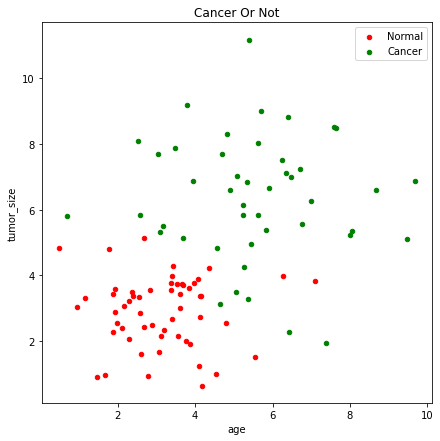

In [5]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)

# 0: 정상
cancer_df[cancer_df.label==0].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='red')
# 1: 암환자
cancer_df[cancer_df.label==1].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='green')
plt.legend(['Normal','Cancer'])
plt.title("Cancer Or Not")
plt.show()

<br>

## 1. Layer 구조
---
* Layer는 크게 3가지로 나누어서 구현하겠습니다.

    1. forward : 순전파 부분
    2. backward : 역전파 부분
    3. update : gradient Descent로 update해야 하는 부분


![Imgur](https://i.imgur.com/HXHigUH.png)

In [6]:
class Layer:
    def forward(self, x):
        """
        해당 Operation의 순전파를 계산
        """
        raise NotImplementedError
        
    def backward(self, grad):
        """
        해당 Operation의 역전파를 계산
        """
        raise NotImplementedError
        
    def update(self, learning_rate):
        """
        [optional]
        해당 Layer에 Weight가 있다면,
        w_old = w_new - learning_rate * dw
        """
        pass

우리가 구현할 2층 신경망을 수식으로 나타내면 아래와 같습니다.

$$
z1 = X\cdot W1 + b1 \\
a1 = relu(z1)  \\
z2 = a1 \cdot W2 + b2  \\
\hat y = sigmoid(z2) \\
CrossEntropy = -y_{true}log(y_{pred})+(1-y_{true})log(1-y_{pred})
$$



## 2. Layer 구현하기
---


### (1) Logit Layer 만들기

In [7]:
# Z = X * W + B - init: w,b,x 
class LogitLayer(Layer):
    def __init__(self, weight, bias):
        self.X = 0
        self.weight = weight
        self.bias = bias
        
        self.dl_dw = 0
        self.dl_db = 0

    def forward(self, X): # return: Z
        self.X = X
        Z = np.matmul(X, self.weight) + self.bias
        return Z
        
    def backward(self, grad): # grad -> 전단계 미분값, return: grad * WT
        self.dl_dw = np.matmul((self.X).T, grad) #+ self.bias
        self.dl_db = np.sum(grad, axis=0)
        return np.matmul(grad, (self.weight).T)
    
    def update(self, learning_rate): # w = w - grad*lr, b = b - grad*lr
        self.weight -= self.dl_dw*learning_rate
        self.bias -= self.dl_db*learning_rate

### (2) Relu Layer 만들기

In [8]:
# A = relu(Z)
class ReluLayer(Layer):
    def __init__(self):
        self.A = 0
        self.Z = 0
    
    def forward(self, X):
        self.Z = X
        self.A = np.maximum(0, self.Z)
        return self.A

        
    def backward(self, grad): # dloss/dz, return 1 or 0
        mask = self.A > 0
        return mask * grad

### (3) Sigmoid-With-Loss Layer 만들기

In [9]:
# A = sigmoid(Z)
class SigmoidWithLossLayer(Layer):
    def __init__(self):
        self.Z = 0
        self.y_hat = 0
        self.y_true = 0
        self.dloss_dz = 0
    def forward(self, X, y_true): # return loss
        """
        Loss 값을 return
        """
        self.Z = X
        self.y_true = y_true
        self.y_hat = 1/(1+np.exp(-self.Z))
        loss = -(y_true*np.log(self.y_hat) + (1-y_true)*np.log(1-self.y_hat))

        return loss
        
        
    def backward(self, grad): # dloss/dz
        """
        가중치 갱신 진행
        """
        self.dloss_dz = self.y_hat - self.y_true
        return self.dloss_dz
        

<br>

## 3. Network 구현
---


In [10]:
class TwoLayerNetwork:
    def __init__(self,num_input=2, num_hidden=200, num_output=1):
        """
        초기 가중치(weights, bias) 설정 및 네트워크 구성
        """
        w0 = np.random.normal(size=(num_input, num_hidden), scale=0.1)
        b0 = np.zeros(shape=(num_hidden))
        w1 = np.random.normal(size=(num_hidden, num_output), scale=0.1)
        b1 = np.zeros(shape=(num_output))

        self.layer1 = LogitLayer(w0,b0)
        self.relu1 = ReluLayer()
        self.layer2 = LogitLayer(w1,b1)

        self.sigmoid_loss = SigmoidWithLossLayer()
        
        self.out = 0
        self.y_hat = 0
        self.out1 = 0


    def forward_layer(self, X):
        """
        순전파 진행
        """
        res = self.layer1.forward(X)
        res = self.relu1.forward(res)
        res = self.layer2.forward(res)
        return res
       
        
    def backward_layer(self, grad):
        """
        역전파 진행
        """
        res = self.layer2.backward(grad)
        res = self.relu1.backward(res)
        res = self.layer1.backward(res)
        
    
    def predict(self, X):
        """
        모델의 예측값 return
        """
        out = self.forward_layer(X)
        self.y_hat = 1/(1+np.exp(-out))
        return self.y_hat
        
    
    def train(self, X, y, learning_rate=0.01):
        """
        가중치 갱신 진행 및 손실값 return(손실값 추이 시각화 위함)
        """
        self.out1 = self.forward_layer(X)
        loss = self.sigmoid_loss.forward(self.out1, y)

        grad = 1 
        grad = self.sigmoid_loss.backward(grad)
        self.backward_layer(grad)
        
        # 가중치 갱신
        self.layer1.update(learning_rate)
        self.layer2.update(learning_rate)
        return np.mean(loss)

<br><br>

# \[ 2층 신경망 학습시키기 \]

----

----

> *구현한 신경망을 학습시켜 결과를 반환해보도록 하겠습니다.*<br>


### (1) 모델 불러오기

In [11]:
model = TwoLayerNetwork()

### (2) 데이터 불러오기

In [12]:
cancer_df = (cancer_df-cancer_df.min())/(cancer_df.max()-cancer_df.min())

x_1 = cancer_df.tumor_size
x_2 = cancer_df.age
data_X = np.stack([x_1,x_2],axis=1)

data_Y = cancer_df.label.values.reshape(-1,1)

### (3) 모델 학습하기

In [13]:
#loss_history에 손실값을 담아주세요.
loss_history = []
"""
loss_history에 손실값을 담아주세요.
epoch : 50000
learning_rate : 0.01
"""
for epoch in range(5000):
    loss = model.train(data_X,data_Y)
    loss_history.append(loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


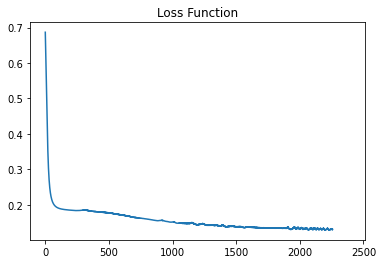

In [14]:
plt.title("Loss Function")
plt.plot(loss_history)
plt.show()

### (4) 결과 확인하기

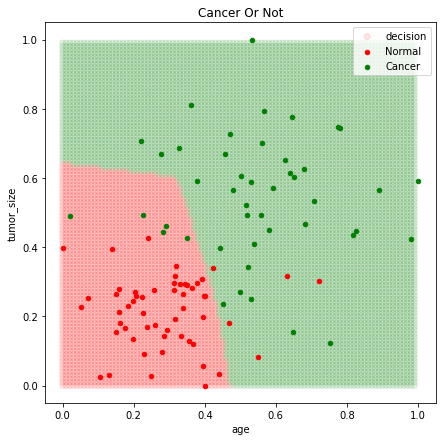

In [15]:
x1s,x2s = np.mgrid[0:1:0.01,0:1:0.01]
xs = np.stack([x1s.ravel(),x2s.ravel()],axis=1)

results = model.predict(xs)

colors = []
for result in results.ravel():
    if result > 0.5:
        colors.append('g')
    else:
        colors.append('r')
        
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
ax.scatter(xs[:,0],xs[:,1],c=colors,alpha=0.1)

# 0: 정상
cancer_df[cancer_df.label==0].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='red')
# 1: 암환자
cancer_df[cancer_df.label==1].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='green')
plt.legend(["decision",'Normal','Cancer'])
plt.title("Cancer Or Not")
plt.show()